#    Deep Learning Midterm Project

Surbhi Gupta 
Digit Recognizer Completion 
Rank: 52
Accuracy: 0.99975

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Dropout, ReLU, LeakyReLU
from tensorflow.keras.layers import Concatenate, MaxPooling2D, LeakyReLU, Softmax, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist

seed=4
tf.random.set_seed(4)

In [34]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

prep = np.concatenate((X_train_raw, X_test_raw))
labels = np.concatenate((y_train_raw, y_test_raw))
labels = labels.astype(int)

In [37]:
valid = pd.read_csv('/kaggle/input/digit-recognizer/train.csv').to_numpy()
execu = pd.read_csv('/kaggle/input/digit-recognizer/test.csv').to_numpy()

In [38]:
# knowing size of the pixels

size_x, size_y = prep[0].shape

In [39]:
y_valid = valid[:, 0]
X_valid = valid[:, 1:]

#one hot encoding
labels = tf.keras.utils.to_categorical(labels)
y_valid = tf.keras.utils.to_categorical(y_valid)

X_prep = prep/255.
X_valid = X_valid/255.
execu = execu/255.

X_prep = X_prep.reshape(-1, size_x, size_y, 1)
X_valid = X_valid.reshape(-1, size_x, size_y, 1)
execu = execu.reshape(-1, size_x, size_y, 1)

In [40]:
print(X_prep.shape, X_valid.shape, execu.shape)

(70000, 28, 28, 1) (42000, 28, 28, 1) (28000, 28, 28, 1)


In [67]:
epochs = 70

steps_per_epoch = X_prep.shape[0]//128 #batch

In [42]:
generating = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1
                            )

In [43]:
batch = 128
image_creator = generating.flow(X_prep, labels, 
                               batch_size=batch, 
                               seed=seed,
                              )

In [44]:
def output_size(inputs,kernel, stride):
    output = (inputs - kernel ) / (stride) + 1
    
    return output

In [45]:
sizex = output_size(28,5,2)
print(sizex)

12.5


In [46]:
def model(size_x=28, size_y=28, depth=1):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input((size_x, size_y,1)))

    model.add(Conv2D(32, (2, 2), name = "layer1" ,activation = 'relu'))
    model.add(Conv2D(32, (4, 4), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))


    model.add(Conv2D(64, (2, 2), name = "layer2" ,activation = 'relu'))
    model.add(Conv2D(64, (4, 4), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), name = "layer3" ,activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))

    return model
model = model()
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 32)        16416     
_________________________________________________________________
batch_normalization_24 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
layer2 (Conv2D)              (None, 11, 11, 64)        8256      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 64)          65600     
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 64)         

In [47]:
r_lr = 0.0003

first = tf.keras.callbacks.EarlyStopping(patience = 20,
                                         min_delta = 1e-4,
                                         restore_best_weights = True)

second = tf.keras.callbacks.ModelCheckpoint(filepath = 'deep_learning', 
                                                 save_best_only = True, 
                                                 save_weights_only = True)

terminate = tf.keras.callbacks.TerminateOnNaN()

schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=r_lr,
                                          decay_steps=steps_per_epoch//4,
                                          decay_rate= 0.75,
                                          staircase=True)

schedule_rate = tf.keras.callbacks.LearningRateScheduler(schedule)

plateau_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 20, verbose = 3)

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=r_lr), 
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )

In [53]:
history1 = model.fit(image_creator, 
                    epochs=epochs, 
                    validation_data=(X_valid, y_valid), 
                    steps_per_epoch= steps_per_epoch,
                    callbacks = [schedule_rate, plateau_rate, second, first, terminate]
                   )

Epoch 1/70
546/546 [==============================] - 22s 40ms/step - loss: 0.1490 - accuracy: 0.9554 - val_loss: 0.0621 - val_accuracy: 0.9834
Epoch 2/70
546/546 [==============================] - 19s 35ms/step - loss: 0.0417 - accuracy: 0.9870 - val_loss: 0.0420 - val_accuracy: 0.9870
Epoch 3/70
546/546 [==============================] - 21s 38ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.0856 - val_accuracy: 0.9719
Epoch 4/70
546/546 [==============================] - 21s 39ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.0203 - val_accuracy: 0.9935
Epoch 5/70
546/546 [==============================] - 21s 39ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0130 - val_accuracy: 0.9962
Epoch 6/70
546/546 [==============================] - 19s 35ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0094 - val_accuracy: 0.9973
Epoch 7/70
546/546 [==============================] - 20s 37ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0095 - val_accuracy:

In [27]:
model.save('file6.csv', save_format = 'csv')

2022-10-28 14:36:08.641459: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [63]:
end_sol = model.predict(execu)
end_sol = np.argmax(end_sol,axis = 1)
model.evaluate(X_valid, y_valid)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.9690e-04 - accuracy: 1.0000


[0.00019690145563799888, 1.0]

[7.8226238e-19 5.1386147e-15 1.0000000e+00 1.8497261e-12 4.8349414e-18
 9.8064079e-21 2.4818391e-16 3.0540335e-14 3.7949390e-14 2.3353408e-19] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


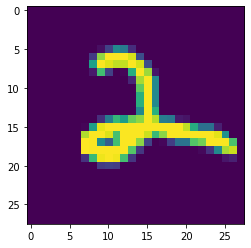

In [65]:
rand = np.random.randint(0,len(X_valid))
model_predict = model.predict(X_valid)
arg_max = np.argmax(model_predict,axis = 1)

print(model_predict[rand], y_valid[rand])
plt.imshow(X_valid[rand])

In [66]:
end_sol = pd.Series(end_sol,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),end_sol],axis = 1)

submission.to_csv("file_dl.csv",index=False)

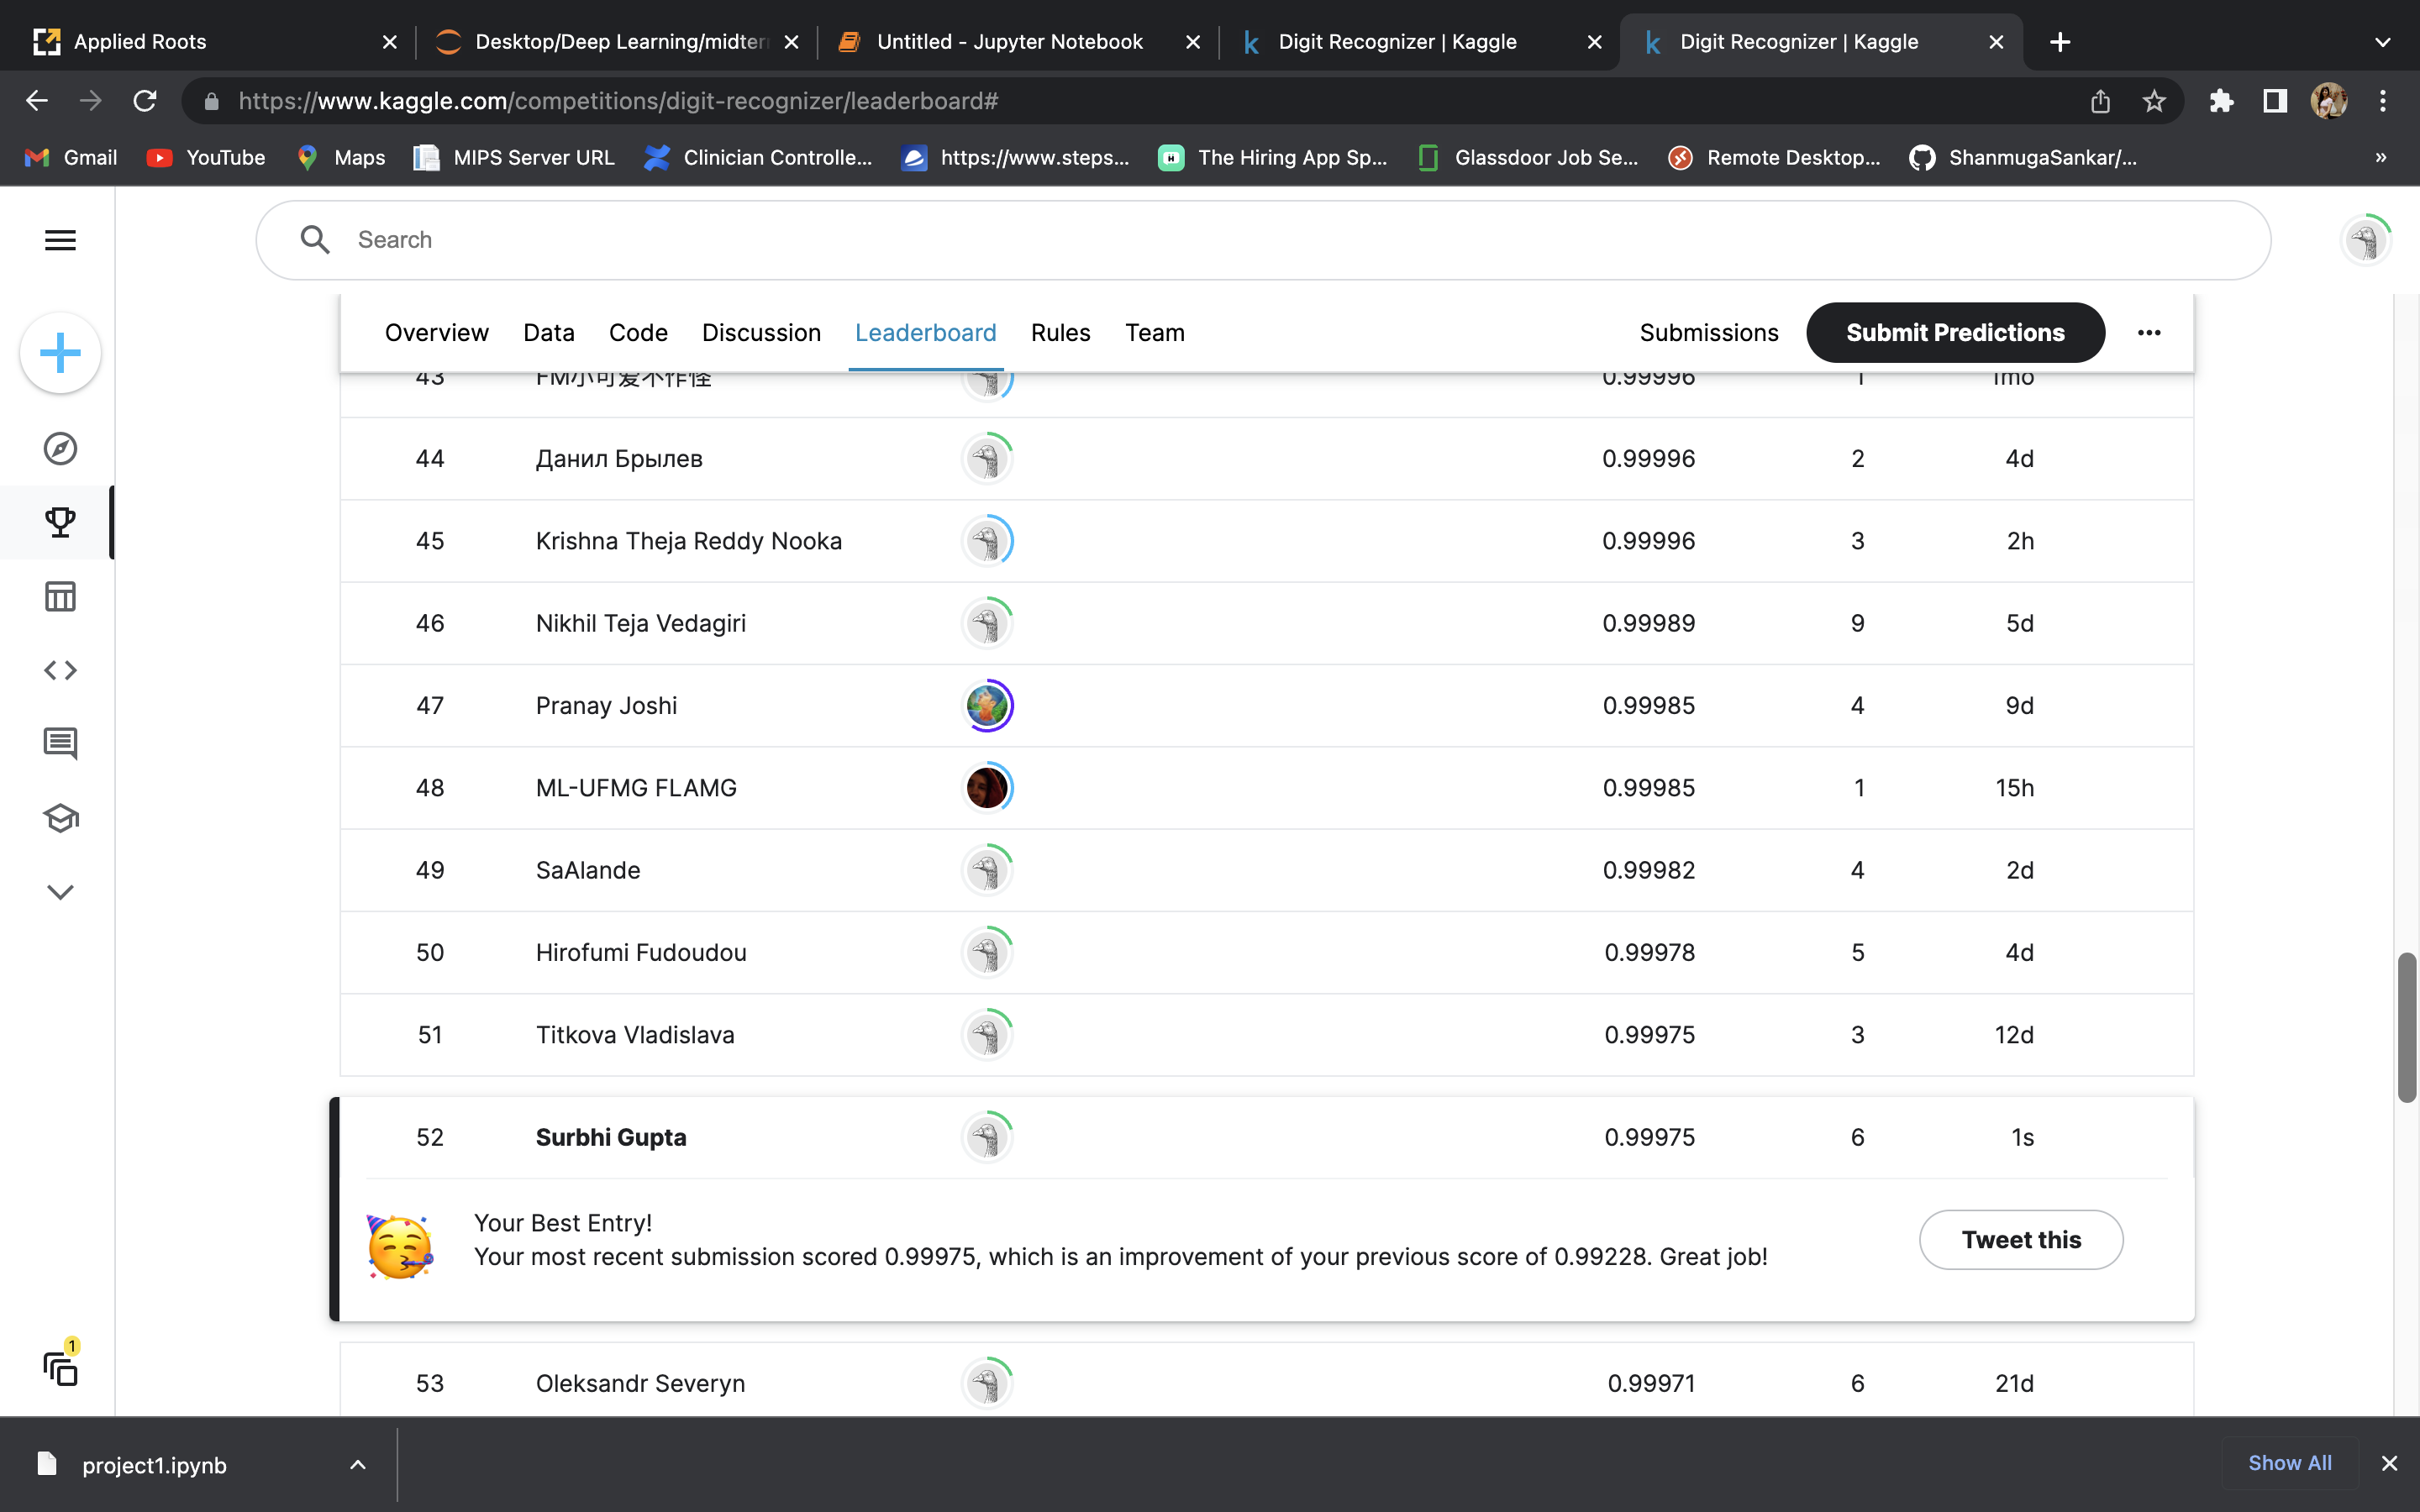

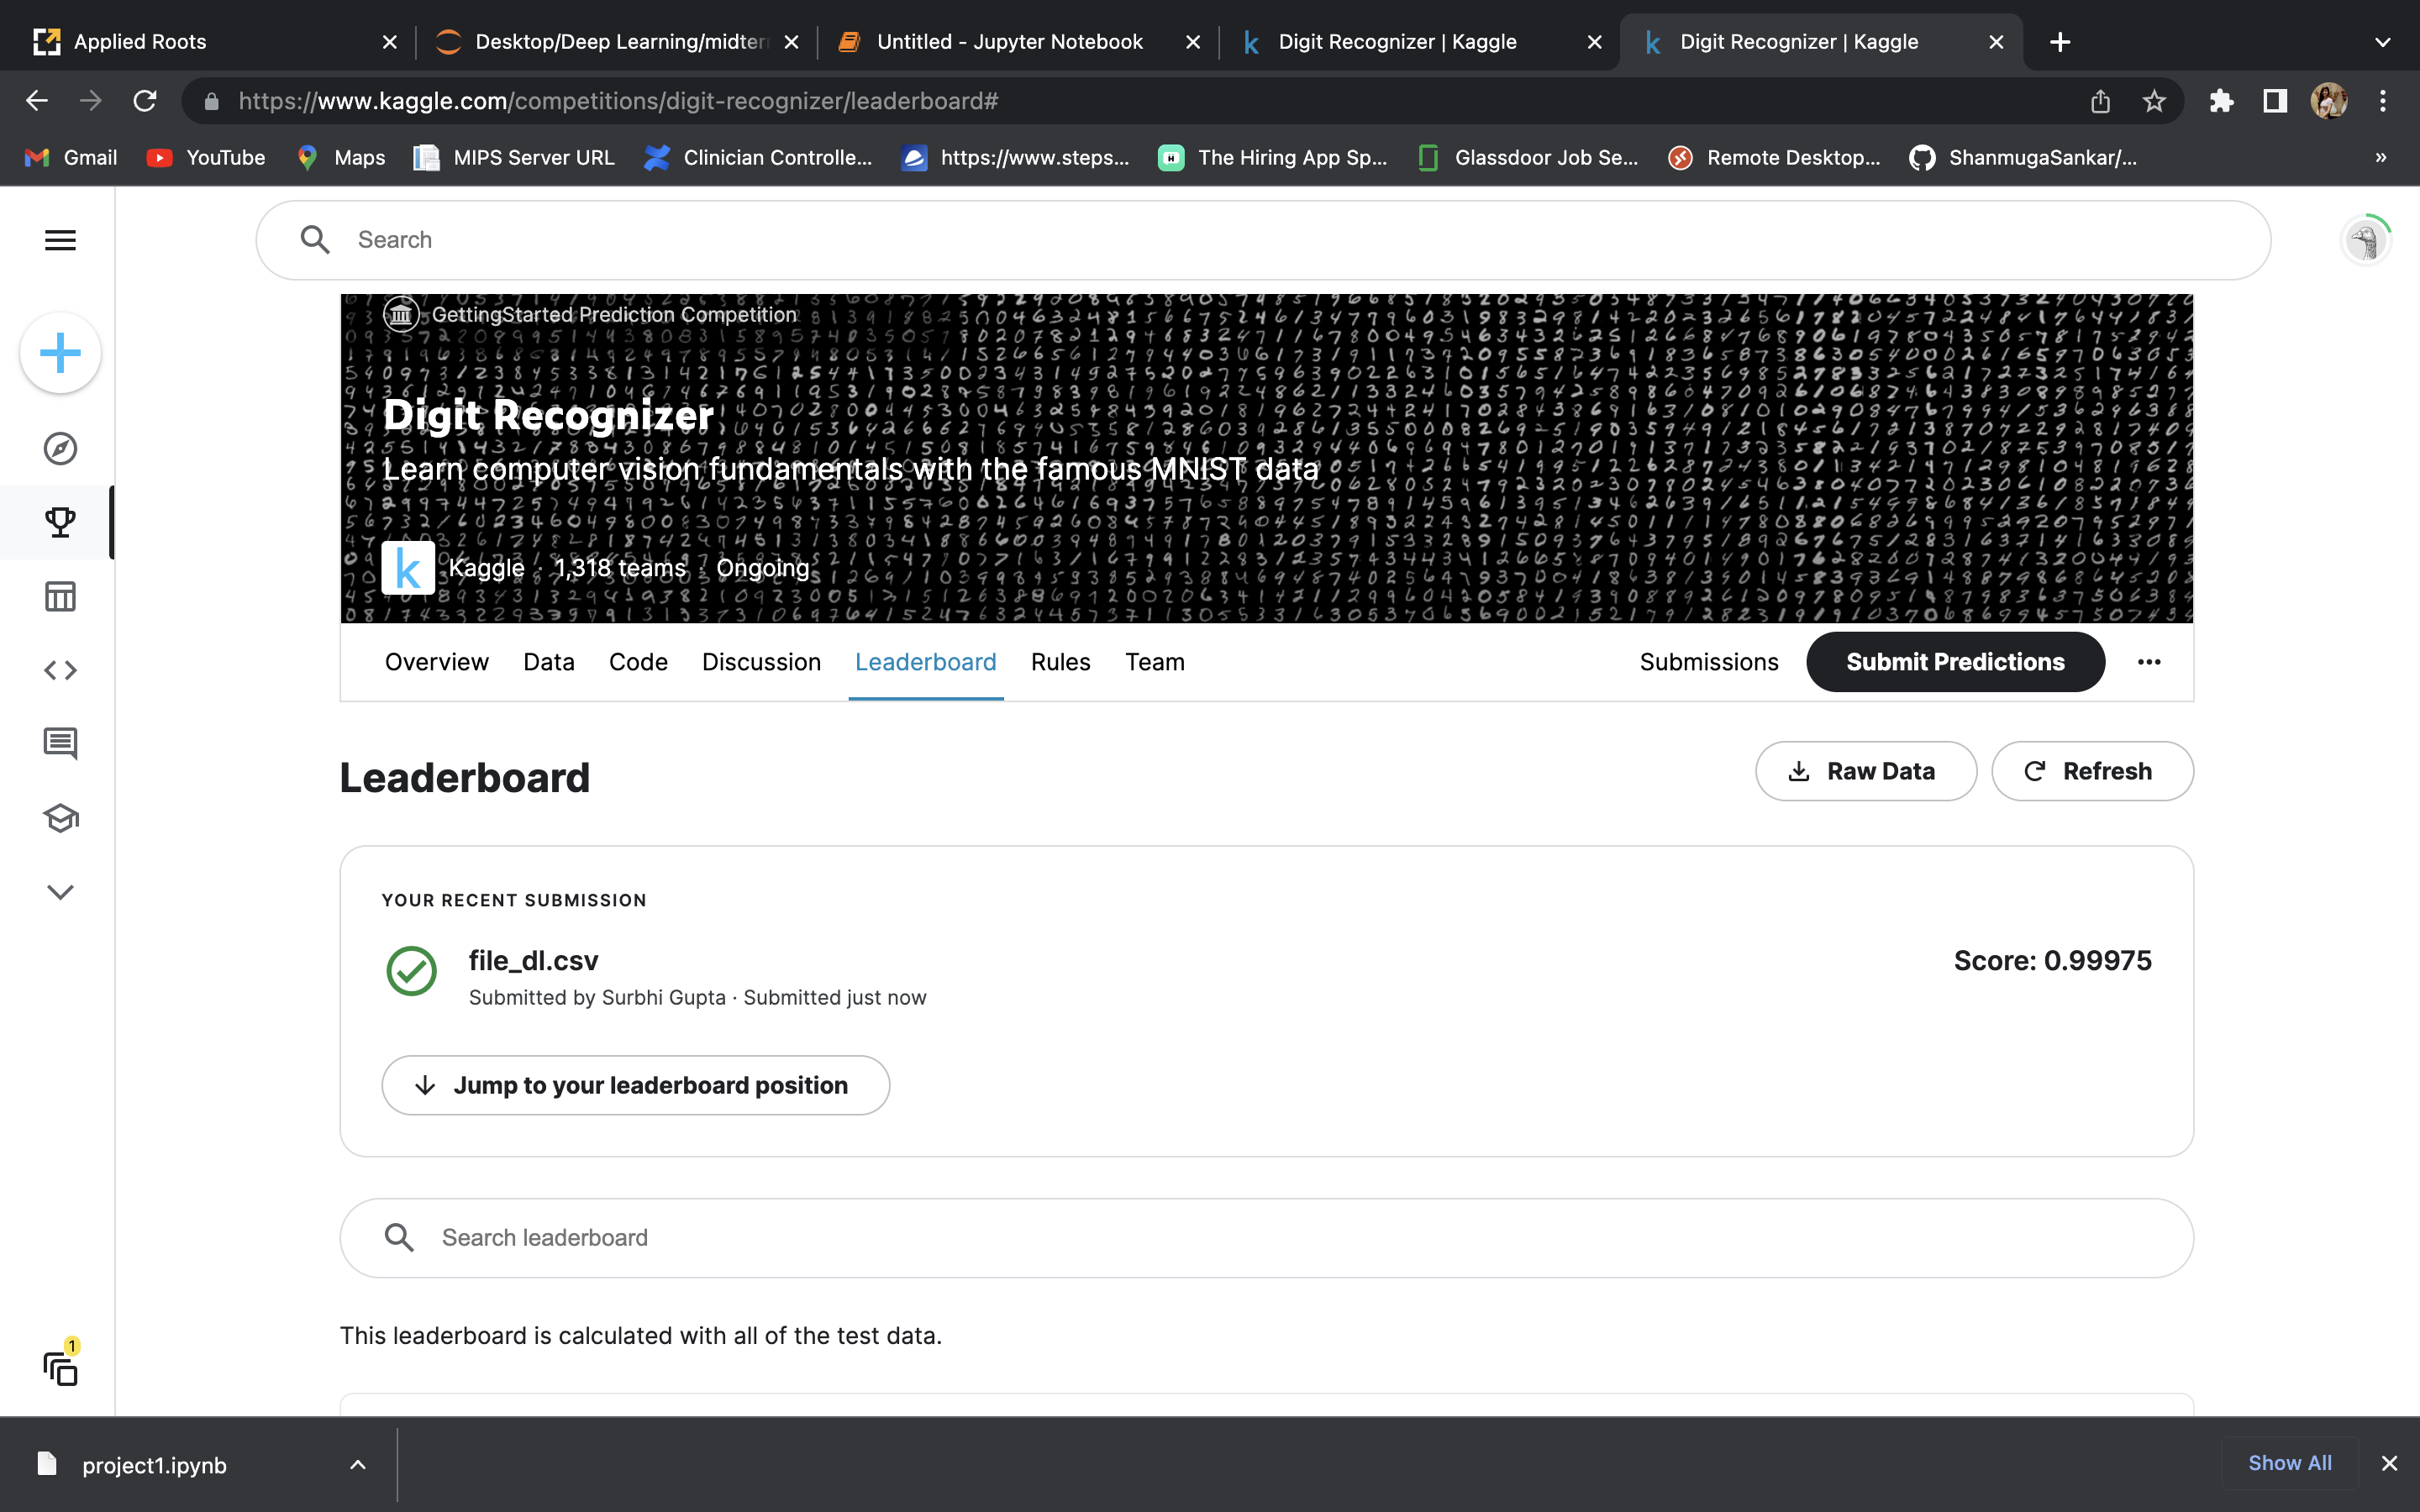